In [29]:
from pandas import read_csv, DataFrame
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
import numpy as np


from base.pandas_constants import AlgorithmConstants, DataFrameConstants


In [30]:
df = read_csv(AlgorithmConstants.FINAL_DF_PATH)
df.head()

df = df[df[DataFrameConstants.DANGER_LEVEL] != 'Baixa']

In [31]:
df.describe()

,processo_numero,latitude,longitude,rain_day,rain_hour,elevation
count,1.927000e+03,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000
mean,8.049312e+09,-8.034787,-34.930820,15.314634,0.658018,47.235599
std,1.863672e+07,0.052360,0.017891,19.046952,1.286009,16.238344
min,8.000042e+09,-8.140337,-34.979501,0.000000,0.000000,7.000000
25%,8.034528e+09,-8.086452,-34.945819,3.650000,0.100000,35.000000
50%,8.053231e+09,-8.009220,-34.929010,9.600000,0.200000,47.000000
75%,8.061411e+09,-8.000093,-34.917472,19.100000,0.600000,60.000000
max,8.113660e+09,-7.961544,-34.886717,83.000000,8.300000,90.000000


In [32]:
label_encoders = {}
categorical_columns = [
    DataFrameConstants.GROUND_TYPE,
    DataFrameConstants.GROUND_AMPLITUDE,
    DataFrameConstants.SLOPE_DEGREE,
    DataFrameConstants.SLOPE_PERCENTAGE,
    DataFrameConstants.DANGER_LEVEL
]

numerical_columns = [
    DataFrameConstants.RAIN_DAY,
    DataFrameConstants.RAIN_HOUR,
    DataFrameConstants.ELEVATION,
    DataFrameConstants.LATITUDE,
    DataFrameConstants.LONGITUDE
]

df_encoded = df.copy()

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df_encoded[column] = label_encoders[column].fit_transform(df_encoded[column])

df_encoded = df_encoded[numerical_columns + categorical_columns]
df_encoded.describe()

,rain_day,rain_hour,elevation,latitude,longitude,ground_type,ground_amplitude,slope_degree,slope_percentage,danger_level
count,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000,1927.000000
mean,15.314634,0.658018,47.235599,-8.034787,-34.930820,2.319668,1.970420,0.981318,1.970420,0.901401
std,19.046952,1.286009,16.238344,0.052360,0.017891,1.480066,0.175489,0.195122,0.175489,0.298200
min,0.000000,0.000000,7.000000,-8.140337,-34.979501,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.650000,0.100000,35.000000,-8.086452,-34.945819,2.000000,2.000000,1.000000,2.000000,1.000000
50%,9.600000,0.200000,47.000000,-8.009220,-34.929010,3.000000,2.000000,1.000000,2.000000,1.000000
75%,19.100000,0.600000,60.000000,-8.000093,-34.917472,3.000000,2.000000,1.000000,2.000000,1.000000
max,83.000000,8.300000,90.000000,-7.961544,-34.886717,5.000000,2.000000,2.000000,2.000000,1.000000


In [33]:
best_k = 0
best_inertia = None
best_columns = None
best_config = None

range_clusters = list(range(1, 30))
random_states = list(range(0, 64))

max_iters = [300, 500, 1000]
algorithms = ['lloyd', 'elkan']
best_k_means = None

In [34]:
scaler = StandardScaler()


df_to_be_scaled = df_encoded
df_scaled = scaler.fit_transform(df_to_be_scaled)

DataFrame(df_scaled).describe()


,0,1,2,3,4,5,6,7,8,9
count,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03,1.927000e+03
mean,1.474920e-17,-1.474920e-17,-1.843650e-18,-3.731548e-15,5.092014e-13,1.327428e-16,-1.253682e-16,-3.097332e-16,-1.253682e-16,5.899680e-17
std,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00,1.000260e+00
min,-8.042552e-01,-5.118072e-01,-2.478457e+00,-2.016389e+00,-2.721776e+00,-1.567680e+00,-1.123107e+01,-5.030572e+00,-1.123107e+01,-3.023591e+00
25%,-6.125737e-01,-4.340270e-01,-7.536960e-01,-9.869897e-01,-8.386258e-01,-2.160383e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01
50%,-3.001067e-01,-3.562469e-01,-1.451260e-02,4.884230e-01,1.011687e-01,4.597828e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01
75%,1.987903e-01,-4.512622e-02,7.862694e-01,6.627827e-01,7.462511e-01,4.597828e-01,1.685992e-01,9.576975e-02,1.685992e-01,3.307325e-01
max,3.554529e+00,5.943946e+00,2.634228e+00,1.399199e+00,2.465748e+00,1.811425e+00,1.685992e-01,5.222112e+00,1.685992e-01,3.307325e-01


In [35]:
SSE = []
results = []

for num_clusters in range_clusters:
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++')
    kmeans.fit(df_scaled)
    inertia = kmeans.inertia_
    SSE.append(inertia)
    print(f'Inertia: {inertia}')
    if best_inertia is None or inertia < best_inertia:
        best_k = num_clusters
        best_k_means = kmeans
        best_inertia = kmeans.inertia_

print(f'Best K: {best_k}, Best Inertia: {best_inertia}')

Inertia: 19269.999999999996
Inertia: 14019.561698833983
Inertia: 11271.339884626605
Inertia: 9646.488627480689
Inertia: 7919.299368776525
Inertia: 6977.892758901335
Inertia: 5931.900485261268
Inertia: 5580.485421465793
Inertia: 5514.439617240253
Inertia: 5116.208773349179
Inertia: 4798.385102026481
Inertia: 4224.100707402268
Inertia: 3793.88128703698
Inertia: 3680.7386101364696
Inertia: 3972.1597267918123
Inertia: 3514.7034777254394
Inertia: 3358.728716344324
Inertia: 3124.1032108855093
Inertia: 3263.29435462359
Inertia: 2906.705419643677
Inertia: 2839.9957549740584
Inertia: 2799.5458875445147
Inertia: 2716.5735641518045
Inertia: 2670.4636047689705
Inertia: 2750.283702068277
Inertia: 2682.1353370827715
Inertia: 2483.9998069417484
Inertia: 2290.601154065284
Inertia: 2232.4982084711933
Best K: 29, Best Inertia: 2232.4982084711933


Text(0, 0.5, 'Inertia')

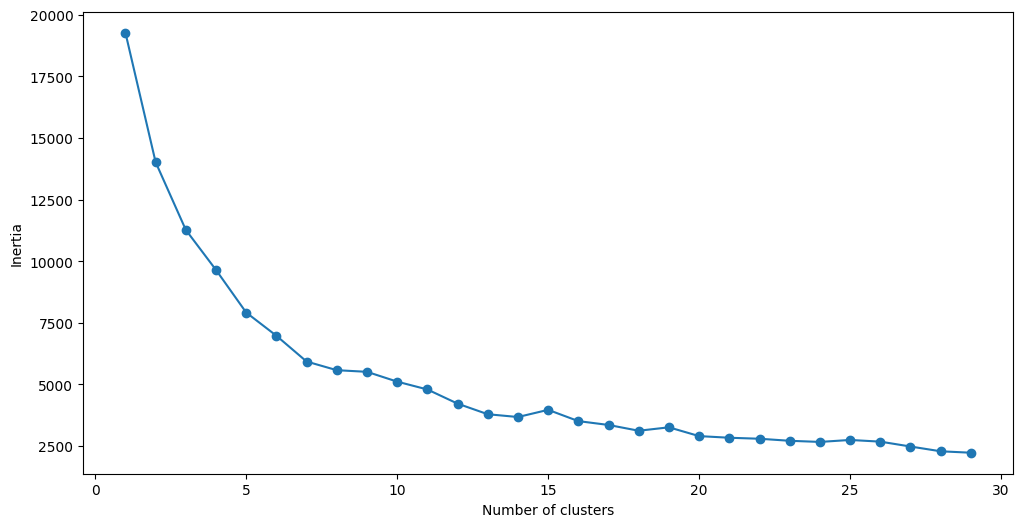

In [36]:
frame = DataFrame({'Cluster':range(1, 30), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')


In [37]:
kmeans = KMeans(n_clusters=8, init='k-means++') # Using elbow curve
kmeans.fit(df_scaled)
print(f'Inertia: {kmeans.inertia_}')   
pred = kmeans.predict(df_scaled)
centroids = kmeans.cluster_centers_

Inertia: 5539.959736306494


In [38]:
df[DataFrameConstants.DISTANCE_TO_CENTROID] = np.sqrt(((df_scaled - centroids[pred]) ** 2).sum(axis=1))

df[DataFrameConstants.CLUSTER] = pred

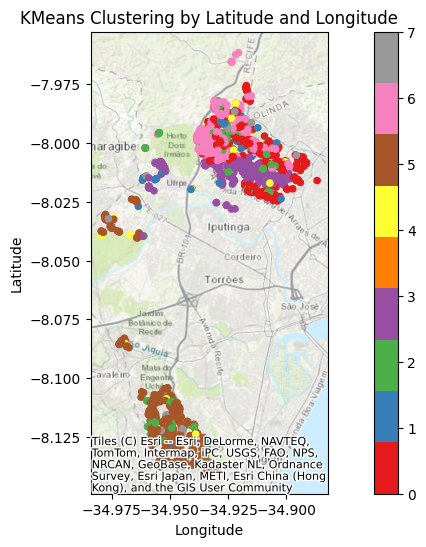

In [39]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[DataFrameConstants.LONGITUDE], df[DataFrameConstants.LATITUDE])
)

# Set a CRS (Coordinate Reference System) for the GeoDataFrame (e.g., WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Plotting with map background
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the GeoDataFrame on the ax
gdf.plot(ax=ax, column=DataFrameConstants.CLUSTER, cmap='Set1', markersize=20, legend=True)

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldTopoMap)

# Customize plot appearance
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('KMeans Clustering by Latitude and Longitude')

plt.show()


In [40]:
df.head()

,processo_numero,latitude,longitude,ground_type,ground_amplitude,slope_degree,slope_percentage,danger_level,rain_day,rain_hour,elevation,distance_to_centroid,cluster
1,8031386621,-7.998090,-34.921421,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,3.8,1.0,23.0,1.092727,0
2,8033507521,-8.116982,-34.951488,LVd2,20 a 100m,10 a 30º,0 a 60%,Media,10.3,0.2,51.0,0.396663,5
5,8030622821,-8.004813,-34.908961,URBANO,20 a 100m,10 a 30º,0 a 60%,Media,9.2,0.4,43.0,1.110146,0
6,8030708021,-8.002648,-34.908863,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,9.6,0.6,53.0,1.100500,6
7,8030626321,-8.001664,-34.903260,LVd4,20 a 100m,10 a 30º,0 a 60%,Media,9.2,0.4,25.0,1.047078,0


In [46]:
df.to_csv('kmeans.csv', index=False, header=True)

In [42]:
df.groupby(DataFrameConstants.CLUSTER)[DataFrameConstants.DISTANCE_TO_CENTROID].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,381.0,1.175449,0.430794,0.460017,0.898127,1.083756,1.332407,3.616800
1,55.0,2.559411,1.720163,0.909046,1.479327,2.301011,2.523050,8.653802
2,184.0,2.050049,0.530643,1.138526,1.592557,2.107725,2.370880,3.914893
3,358.0,1.377513,0.576487,0.210602,0.915050,1.348549,1.729851,3.097202
4,59.0,2.335213,0.878074,0.759834,1.771457,2.305719,2.708586,5.795433
5,410.0,1.616706,1.009259,0.396663,0.975316,1.327025,2.038805,5.484298
6,411.0,0.943655,0.382721,0.290734,0.704704,0.874233,1.059733,2.631511
7,69.0,2.696388,0.510909,1.794313,2.305878,2.777839,3.017603,4.327017


In [44]:
df.groupby(DataFrameConstants.CLUSTER)[DataFrameConstants.RAIN_HOUR].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,381.0,0.406824,0.599786,0.0,0.10,0.2,0.5,4.6
1,55.0,0.856364,1.889715,0.0,0.10,0.2,0.6,8.3
2,184.0,0.436413,0.695678,0.0,0.00,0.2,0.5,4.6
3,358.0,0.411732,0.533712,0.0,0.10,0.2,0.5,3.1
4,59.0,1.562712,1.310291,0.0,0.45,1.3,2.8,3.5
5,410.0,0.390000,0.521492,0.0,0.10,0.2,0.5,3.1
6,411.0,0.405839,0.564144,0.0,0.10,0.2,0.5,3.4
7,69.0,6.076812,1.420765,3.5,4.80,5.2,7.5,8.3


In [45]:
df.groupby(DataFrameConstants.CLUSTER)[DataFrameConstants.RAIN_DAY].describe()


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,381.0,10.377165,8.464926,0.0,3.600,9.4,17.8,49.1
1,55.0,23.009091,26.738011,1.0,4.350,13.4,20.8,83.0
2,184.0,11.100543,9.345374,0.0,2.900,9.6,19.0,49.1
3,358.0,10.695810,9.000072,0.0,3.325,9.2,17.8,49.1
4,59.0,80.701695,8.595498,49.1,83.000,83.0,83.0,83.0
5,410.0,11.242683,10.204935,0.0,3.300,8.0,17.8,49.1
6,411.0,10.914842,8.547212,0.0,3.650,9.4,19.0,35.6
7,69.0,66.139130,24.990705,19.1,49.100,83.0,83.0,83.0


In [47]:
df.groupby(DataFrameConstants.CLUSTER)[DataFrameConstants.ELEVATION].describe()


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,381.0,35.328084,8.978921,10.0,31.0,35.0,41.0,57.0
1,55.0,29.363636,9.661615,12.0,21.0,28.0,33.0,48.0
2,184.0,51.880435,16.620050,17.0,41.0,50.0,65.0,83.0
3,358.0,44.843575,16.195345,7.0,33.0,42.0,59.0,74.0
4,59.0,47.983051,17.009624,16.0,32.0,49.0,62.0,79.0
5,410.0,48.865854,16.671251,14.0,38.0,49.0,60.0,90.0
6,411.0,58.919708,9.918491,42.0,50.0,59.0,66.0,86.0
7,69.0,47.333333,18.134844,7.0,35.0,48.0,63.0,79.0
